# Setup

In [2]:
!pip install ratelimit


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import google.generativeai as genai
from ratelimit import limits, sleep_and_retry
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import re

# Translating
the data will be translated from TH -> EN to improve the accuracy when used on LLMs.

In [ ]:
# import os
# from google.cloud import translate_v2 as translate

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./gcp-key.json"
# client = translate.Client()

In [ ]:
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# answers_train = train_df[['ID', 'answer']]
# answers_test = test_df[['ID', 'answer']]

In [ ]:
# answers_train['answer'] = answers_train['answer'].apply(lambda x: client.translate(x, source_language='th', target_language='en')['translatedText'])
# answers_test['answer'] = answers_test['answer'].apply(lambda x: client.translate(x, source_language='th', target_language='en')['translatedText'])

In [ ]:
# print(answers_train.shape, answers_test.shape, train_df.shape, test_df.shape)
# train_df['answer'] = answers_train['answer']
# test_df['answer'] = answers_test['answer']

# train_df.to_csv('train_EN.csv', index=False)
# test_df.to_csv('test_EN.csv', index=False)

# Prompting

In [4]:
# from google.colab import userdata
# api_key = userdata.get('gemini_api_key')

import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [5]:
genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.0-flash-001", generation_config=generation_config)

In [61]:
@sleep_and_retry
@limits(calls=14, period=60)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [7]:
train_df = pd.read_csv('train_EN.csv')
test_df = pd.read_csv('test_EN.csv')

In [8]:
train_df.head()

,ID,set,question,answer,score
0,0,Q2,Hamtube is an online video viewing platform th...,The granularity should be low because we want ...,0.0
1,1,Q3,Hamtube is an online video viewing platform th...,Agree because it is collecting data from multi...,5.0
2,2,Q2,Hamtube is an online video viewing platform th...,Granularity should be #checkout events/ #cooki...,5.0
3,3,Q3,Hamtube is an online video viewing platform th...,"Agree. Let X~Binomial(N,p), where p is the rat...",2.0
4,4,Q1,Hamtube is an online video viewing platform th...,"Agreed, because A/B Testing is an effective wa...",4.5


In [9]:
test_df.head()

,ID,set,question,answer
0,362,Q3,Hamtube is an online video viewing platform th...,"Yes, because in this problem, the variable is ..."
1,363,Q4,Hamtube is an online video viewing platform th...,50/50 has the advantage of being able to colle...
2,364,Q2,Hamtube is an online video viewing platform th...,1. Number of views 2. Number of ad clicks 3. T...
3,365,Q3,Hamtube is an online video viewing platform th...,"Agree, because a click can have two possible o..."
4,366,Q4,Hamtube is an online video viewing platform th...,50/50 - It will take less time to collect data...


In [10]:
train_df['score'].value_counts()

score
5.00    150
1.00     58
0.00     50
3.00     26
2.00     20
4.00     15
0.50     10
4.50      9
3.50      8
1.50      8
2.50      5
4.25      1
0.75      1
4.75      1
Name: count, dtype: int64

In [117]:
# sorting sucks
# Q1_train = train_df[train_df['set'] == 'Q1'].sort_values('score', ascending=False).reset_index(drop=True)
# Q2_train = train_df[train_df['set'] == 'Q2'].sort_values('score', ascending=False).reset_index(drop=True)
# Q3_train = train_df[train_df['set'] == 'Q3'].sort_values('score', ascending=False).reset_index(drop=True)
# Q4_train = train_df[train_df['set'] == 'Q4'].sort_values('score', ascending=False).reset_index(drop=True)

Q1_train = train_df[train_df['set'] == 'Q1']
Q2_train = train_df[train_df['set'] == 'Q2']
Q3_train = train_df[train_df['set'] == 'Q3']
Q4_train = train_df[train_df['set'] == 'Q4']

Q1_test = test_df[test_df['set'] == 'Q1']
Q2_test = test_df[test_df['set'] == 'Q2']
Q3_test = test_df[test_df['set'] == 'Q3']
Q4_test = test_df[test_df['set'] == 'Q4']

In [118]:
def get_score_counts(df: pd.DataFrame) -> pd.DataFrame:
    q1_counts = Q1_train['score'].value_counts().reset_index()
    q1_counts.columns = ['score', 'count_q1']
    q2_counts = Q2_train['score'].value_counts().reset_index()
    q2_counts.columns = ['score', 'count_q2']
    q3_counts = Q3_train['score'].value_counts().reset_index()
    q3_counts.columns = ['score', 'count_q3']
    q4_counts = Q4_train['score'].value_counts().reset_index()
    q4_counts.columns = ['score', 'count_q4']

    # merge both DataFrames on the 'score' column
    merged_counts = (
        q1_counts
        .merge(q2_counts, on='score', how='outer')
        .merge(q3_counts, on='score', how='outer')
        .merge(q4_counts, on='score', how='outer')
        .fillna(0)  # Replace NaN with 0
    )

    merged_counts[['count_q1', 'count_q2', 'count_q3', 'count_q4']] = merged_counts[['count_q1', 'count_q2', 'count_q3', 'count_q4']].astype(int)

    return merged_counts

In [119]:
score_counts = get_score_counts(train_df)
score_counts

,score,count_q1,count_q2,count_q3,count_q4
0,0.00,2,43,4,1
1,0.50,7,1,0,2
2,0.75,0,1,0,0
3,1.00,39,0,9,10
4,1.50,7,1,0,0
5,2.00,8,1,10,1
6,2.50,1,4,0,0
7,3.00,10,3,1,12
8,3.50,0,8,0,0
9,4.00,3,5,0,7


In [120]:
def limit_samples_by_scores(df: pd.DataFrame, limit: int):
  return df.groupby('score').head(limit)

In [121]:
Q1_train = limit_samples_by_scores(Q1_train, 45)
Q2_train = limit_samples_by_scores(Q2_train, 45)
Q3_train = limit_samples_by_scores(Q3_train, 45)
Q4_train = limit_samples_by_scores(Q4_train, 45)

In [122]:
score_counts = get_score_counts(train_df)
score_counts

,score,count_q1,count_q2,count_q3,count_q4
0,0.00,2,43,4,1
1,0.50,7,1,0,2
2,0.75,0,1,0,0
3,1.00,39,0,9,10
4,1.50,7,1,0,0
5,2.00,8,1,10,1
6,2.50,1,4,0,0
7,3.00,10,3,1,12
8,3.50,0,8,0,0
9,4.00,3,5,0,7


In [123]:
Q1_train

,ID,set,question,answer,score
4,4,Q1,Hamtube is an online video viewing platform th...,"Agreed, because A/B Testing is an effective wa...",4.5
5,5,Q1,Hamtube is an online video viewing platform th...,Hamtaro should use A/B testing for testing bec...,1.0
8,8,Q1,Hamtube is an online video viewing platform th...,Because A/B testing is about comparing the res...,1.0
11,11,Q1,Hamtube is an online video viewing platform th...,A/B testing is useful for Hamtaro to test ad p...,5.0
13,13,Q1,Hamtube is an online video viewing platform th...,Hamtaro should use A/B testing because A/B tes...,1.0
...,...,...,...,...,...
338,338,Q1,Hamtube is an online video viewing platform th...,Agreed because the two situations are differen...,1.0
345,345,Q1,Hamtube is an online video viewing platform th...,"Agree, because what Hamtaro wants to test is a...",1.0
352,352,Q1,Hamtube is an online video viewing platform th...,It should be used because it allows Hamtaro to...,4.0
355,355,Q1,Hamtube is an online video viewing platform th...,It should be used to test the hypothesis that ...,1.0


In [124]:
Q1_test

,ID,set,question,answer
10,372,Q1,Hamtube is an online video viewing platform th...,Agree because AB Testing will clearly show the...
12,374,Q1,Hamtube is an online video viewing platform th...,"If it is a test in 2 different locations, if H..."
13,375,Q1,Hamtube is an online video viewing platform th...,A/B testing should be used because Hamtaro can...
19,381,Q1,Hamtube is an online video viewing platform th...,1. It can be divided into many experiments tha...
28,390,Q1,Hamtube is an online video viewing platform th...,You can test whether placing ads in the same p...
33,395,Q1,Hamtube is an online video viewing platform th...,A/B testing should be used because it is an ef...
39,401,Q1,Hamtube is an online video viewing platform th...,It should be used because it is a method of ex...
40,402,Q1,Hamtube is an online video viewing platform th...,A/B testing helps Hamtaro gain accurate data a...
41,403,Q1,Hamtube is an online video viewing platform th...,Hamtaro should use A/B testing because it allo...
43,405,Q1,Hamtube is an online video viewing platform th...,It should be used because there is randomness ...


In [125]:
Q1_train['question'].iloc[0]

'Hamtube is an online video viewing platform that allows users to upload, share, and watch videos. Hamtaro is the head of Hamtube’s marketing team, and he wants to know if moving the placement of ads will increase sales (more users clicking on ads). So he decides to conduct A/B testing. Explain why Hamtaro should use A/B testing in his experiments, or offer a counter-argument if you disagree, and explain why.'

In [126]:
def extract_valid_score(response: str) -> float:
    allowed_scores = {i * 0.5 for i in range(11)}  # {0, 0.5, 1, ..., 5}
    # extract the first valid number from the response
    match = re.search(r"\d+(\.\d+)?", response.strip())
    
    if match:
        num = float(match.group())
        
        # round to nearest 0.5
        rounded_num = round(num * 2) / 2  # ensure 0.5 intervals
        if rounded_num in allowed_scores:
            return rounded_num
    
    return 0.0

extract_valid_score("The answer is 3.5")

3.5

In [127]:
def generate_predictions(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    prompt = f"""
You are a text regression model. Given an answer to a question, predict a numerical score between 0 and 5, with intervals of 0.5.
The question is: "{train_df['question'].iloc[0]}".
Here are some examples to help you get started:\n\n"""
    for i, row in train_df.iterrows():
        prompt += f"Answer: {row['answer']}\nScore: {row['score']}\n\n"
    
    # print(prompt)
    predictions = pd.DataFrame(columns=['ID', 'score'])
    # limit = 30
    # count = 0
    for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
        # add chain of thoughts here
        prompt_with_test = f"{prompt}What score would you give to the following answer?\n\n{row['answer']}\n\n"
        # print(prompt_with_test)
        response: str = generate_content_with_rate_limit(prompt_with_test)
        # print(response)
        score = extract_valid_score(response)
        predictions.loc[len(predictions)] = [row['ID'], score]
        # count += 1
        # if count == limit:
        #     break

    return predictions


In [128]:
def generate_predictions_cot(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    prompt = f"""
You are a text regression model. Given an answer to a question, predict a numerical score between 0 and 5, with intervals of 0.5.
The question is: "{train_df['question'].iloc[0]}".
Here are some examples:\n\n"""
    
    for i, row in train_df.iterrows():
        prompt += f"Answer: {row['answer']}\nScore: {row['score']}\n\n"

    predictions = pd.DataFrame(columns=['ID', 'score'])

    for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
        # **Simplified CoT Prompting**
        prompt_with_test = f"""{prompt}
Now, analyze the following answer and determine a fair score.
Answer: {row['answer']}

Explanation: (Briefly justify the score)
Predicted Score: (Provide a number between 0 and 5 in 0.5 increments)
"""
        response: str = generate_content_with_rate_limit(prompt_with_test)
        
        # Extract score reliably
        score = extract_valid_score(response)  # Ensure extraction works well
        predictions.loc[len(predictions)] = [row['ID'], score]

    return predictions


In [129]:
pred_Q1 = generate_predictions(Q1_train, Q1_test)
# pred_Q1 = generate_predictions_cot(Q1_train, Q1_test)

100%|██████████| 22/22 [01:06<00:00,  3.00s/it]


In [130]:
pred_Q2 = generate_predictions(Q2_train, Q2_test)
# pred_Q2 = generate_predictions_cot(Q2_train, Q2_test)

100%|██████████| 23/23 [02:03<00:00,  5.35s/it]


In [132]:
pred_Q3 = generate_predictions(Q3_train, Q3_test)
# pred_Q3 = generate_predictions_cot(Q3_train, Q3_test)

100%|██████████| 23/23 [01:06<00:00,  2.88s/it]


In [133]:
pred_Q4 = generate_predictions(Q4_train, Q4_test)
# pred_Q4 = generate_predictions_cot(Q4_train, Q4_test)

100%|██████████| 22/22 [01:08<00:00,  3.10s/it]


In [134]:
pred_df = pd.concat([pred_Q1, pred_Q2, pred_Q3, pred_Q4])
pred_df = pred_df.sort_values(by='ID')
# remove .0 from ID
pred_df['ID'] = pred_df['ID'].astype(int)
pred_df.to_csv('predictions.csv', index=False)

In [34]:
pred_df

,ID,score
0,362,5.0
0,363,5.0
0,364,1.0
1,365,5.0
1,366,4.0
...,...,...
22,447,1.0
19,448,1.0
20,449,1.0
21,450,1.0


In [137]:
base_predictions = pd.read_csv('./predictions/predictions_base.csv')
pred_cot1 = pd.read_csv('./predictions/predictions_cot1.csv')
pred_sorted = pd.read_csv('./predictions/predictions_sorted.csv')
pred_limit10 = pd.read_csv('./predictions/predictions_limit10.csv')
pred_limit18 = pd.read_csv('./predictions/predictions_limit18.csv')
pred_limit25 = pd.read_csv('./predictions/predictions_limit25.csv')
pred_limit40 = pd.read_csv('./predictions/predictions_limit40.csv')
pred_limit45 = pd.read_csv('./predictions/predictions_limit45.csv')

In [139]:
def avg_diff(a: pd.DataFrame, b: pd.DataFrame) -> float:
    merged = pd.merge(a, b, on='ID', how='inner')
    merged['score_diff'] = abs(merged['score_x'] - merged['score_y'])
    avg_difference = merged['score_diff'].mean()

    return avg_difference

# print(f"Average difference between base and limit25 predictions: {avg_diff(base_predictions, pred_limit25)}")
# print(f"Average difference between base and limit18 predictions: {avg_diff(base_predictions, pred_limit18)}")
# print(f"Average difference between base and limit10 predictions: {avg_diff(base_predictions, pred_limit10)}")
# print(f"Average difference between base and sorted predictions: {avg_diff(base_predictions, pred_sorted)}")
print(f"Average difference between base and limit40 predictions: {avg_diff(base_predictions, pred_limit40)}")

print(f"Average difference between limit40 and limit45 predictions: {avg_diff(pred_limit40, pred_limit45)}")

Average difference between base and limit40 predictions: 0.18888888888888888
Average difference between limit40 and limit45 predictions: 0.14444444444444443


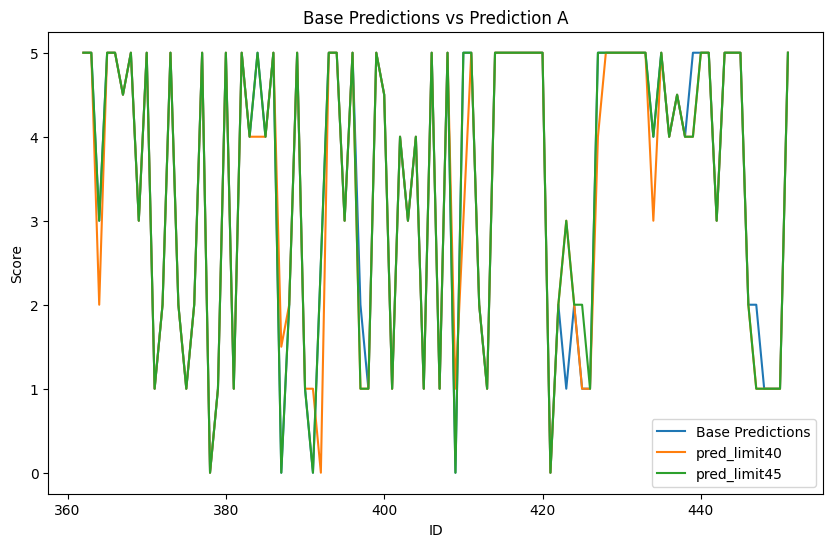

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(base_predictions['ID'], base_predictions['score'], label='Base Predictions')
# plt.plot(pred_sorted['ID'], pred_sorted['score'], label='pred_sorted')
# plt.plot(pred_cot1['ID'], pred_cot1['score'], label='pred_cot1')
# plt.plot(pred_limit10['ID'], pred_limit10['score'], label='pred_limit10')
# plt.plot(pred_limit18['ID'], pred_limit18['score'], label='pred_limit18')
# plt.plot(pred_limit25['ID'], pred_limit25['score'], label='pred_limit25')
plt.plot(pred_limit40['ID'], pred_limit40['score'], label='pred_limit40')
plt.plot(pred_limit45['ID'], pred_limit45['score'], label='pred_limit45')
plt.xlabel('ID')
plt.ylabel('Score')
plt.legend()
plt.title('Base Predictions vs Prediction A')
plt.show()